In [1]:
import numpy as np
import pandas as pd

import time

import matplotlib.pyplot as plt
import os
import re
import seaborn as sns

In [2]:

import tensorflow as tf
import tensorflow_hub as hub


In [ ]:
import torch
from transformers import BertTokenizer, BertModel

# OPTIONAL: if you want to have more information on what's happening, activate the logger as follows
#import logging
#logging.basicConfig(level=logging.INFO)


In [ ]:

# Load pre-trained model tokenizer (vocabulary)
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

In [ ]:
# Load pre-trained model (weights)
modelBert = BertModel.from_pretrained('bert-base-uncased',
                                  output_hidden_states = True, # Whether the model returns all hidden-states.
                                  )
# Put the model in "evaluation" mode, meaning feed-forward operation.
modelBert.eval()

In [ ]:
def bert_embedding(strtext):
    marked_text = "[CLS] " + strtext + " [SEP]"
    # Tokenize our sentence with the BERT tokenizer.
    tokenized_text = tokenizer.tokenize(marked_text)
    # Map the token strings to their vocabulary indeces.
    indexed_tokens = tokenizer.convert_tokens_to_ids(tokenized_text)
    segments_ids = [1] * len(tokenized_text)
    # Convert inputs to PyTorch tensors
    tokens_tensor = torch.tensor([indexed_tokens])
    segments_tensors = torch.tensor([segments_ids])
    # Run the text through BERT, and collect all of the hidden states produced
    # from all 12 layers. 
    with torch.no_grad():
        outputs = modelBert(tokens_tensor, segments_tensors)
        # Evaluating the model will return a different number of objects based on 
        # how it's  configured in the `from_pretrained` call earlier. In this case, 
        # becase we set `output_hidden_states = True`, the third item will be the 
        # hidden states from all layers. See the documentation for more details:
        # https://huggingface.co/transformers/model_doc/bert.html#bertmodel
        hidden_states = outputs[2]
    
    # `token_vecs` is a tensor with shape [22 x 768]
    token_vecs = hidden_states[-2][0]

    # Calculate the average of all 22 token vectors. ----<
    sentence_embedding = np.array(torch.mean(token_vecs, dim=0))
    sentence_embedding = sentence_embedding / np.linalg.norm(sentence_embedding)
    return sentence_embedding

In [ ]:
!pip install -U sentence-transformers

In [ ]:
from sentence_transformers import SentenceTransformer
modelST = SentenceTransformer('paraphrase-MiniLM-L6-v2')

#Our sentences we like to encode
sentences = ['This framework generates embeddings for each input sentence',
    'Sentences are passed as a list of string.',
    'The quick brown fox jumps over the lazy dog.']

#Sentences are encoded by calling model.encode()
embeddings = modelST.encode(sentences)

#Print the embeddings
for sentence, embedding in zip(sentences, embeddings):
    print("Sentence:", sentence)
    print("Embedding:", embedding)
    print("")

In [ ]:
text = "Here is the sentence I want embeddings for."


print((bert_embedding(text)))


In [ ]:
print(np.inner(bert_embedding('small'),bert_embedding('sentence')))

In [ ]:
sentence_embedding.shape

In [3]:
str_state = 'GA'
file = 'agent_comments_sales_'+str_state
#file = 'agent_comments_testdf'
#READ THE SALES DATA - STATE
#df_sales = pd.read_feather(file + '_withsentiment.fea')
df_sales = pd.read_feather(file + '_sentencecomposition.fea')


In [4]:
module_url = "https://tfhub.dev/google/universal-sentence-encoder/4"
model = hub.load(module_url)
print ("module %s loaded" % module_url)


module https://tfhub.dev/google/universal-sentence-encoder/4 loaded


In [5]:
def embed(input):
    return model(input)

In [6]:
embed(['house']).numpy()

array([[-4.48741540e-02, -1.17531838e-02, -1.83692258e-02,
        -1.49300387e-02, -1.84926242e-02,  2.96741333e-02,
         4.57403399e-02, -5.61308451e-02,  1.76581424e-02,
        -1.05286548e-02,  4.84684594e-02, -3.60982493e-02,
         2.54628230e-02, -2.57100891e-02,  2.76781414e-02,
        -8.94726720e-03, -8.30372423e-02,  3.15634608e-02,
         1.36838760e-02, -8.92550126e-03, -1.66827831e-02,
         5.89211807e-02,  7.68065676e-02, -1.31510049e-02,
         4.49627414e-02, -3.41357812e-02,  2.70094294e-02,
        -6.89992681e-02,  3.84558700e-02, -3.77446264e-02,
        -5.50057143e-02,  1.48791326e-02, -2.18885764e-02,
         2.28994116e-02, -3.24481390e-02, -1.07792700e-02,
         8.42211023e-02,  1.68718435e-02,  1.39755104e-02,
         1.45233516e-05,  4.45399396e-02,  4.35604379e-02,
         7.21272677e-02, -5.74962422e-02, -6.96459040e-02,
         3.55688706e-02, -3.50801423e-02,  4.35770452e-02,
        -1.47837773e-02, -3.39668430e-02,  6.89795539e-0

In [7]:
np.inner(embed(['1']).numpy(),embed(['-1']).numpy())

array([[1.0000002]], dtype=float32)

In [8]:
columns = ['publicremarks', 'clean_publicremarks', 'clean_publicremarks_additional_words',
          'clean_publicremarks_nopunct', 'clean_publicremarks_nopunct_additional_words', 
          'clean_publicremarks_stemmed', 
          'clean_publicremarks_stemmed_additional_words', 'clean_publicremarks_lemmatized',
          'clean_publicremarks_lemmatized_additional_words']

In [9]:
columns = ['publicremarks', 'clean_publicremarks', 'clean_publicremarks_additional_words',
          'clean_publicremarks_nopunct', 
          'clean_publicremarks_stemmed', 'clean_publicremarks_lemmatized']

In [10]:
embed([df_sales['publicremarks'].values[500]]).numpy()

array([[-5.24229631e-02, -5.55945709e-02, -4.41210419e-02,
        -5.90065196e-02,  4.86078300e-02, -3.54217999e-02,
         3.27230655e-02, -5.41125946e-02,  5.60273565e-02,
        -6.06607012e-02, -2.82838456e-02, -2.06618384e-02,
         2.15711389e-02, -6.86271042e-02, -6.72533959e-02,
         6.86386824e-02,  6.59395009e-03,  5.32062054e-02,
         5.37439734e-02,  1.18398834e-02,  3.03179882e-02,
        -2.66683176e-02,  6.43523112e-02, -6.08987398e-02,
        -5.87863065e-02, -8.90954770e-03, -4.29713726e-02,
        -3.17339995e-03, -1.31026870e-02,  6.17787018e-02,
        -2.68983841e-02, -1.43213281e-02,  1.77409407e-02,
         1.94270145e-02, -5.96522167e-02, -3.22199911e-02,
         6.22961149e-02,  5.85397817e-02, -4.41989042e-02,
         4.04004008e-02,  6.78849267e-03,  4.03384753e-02,
        -2.25449763e-02,  5.57429306e-02, -6.79708496e-02,
        -4.68418524e-02, -4.91078869e-02, -3.86885554e-02,
        -2.93384828e-02,  3.03604547e-03, -6.35173544e-0

In [11]:
embed([df_sales['publicremarks'].values[501]]).numpy()

array([[-0.00555682, -0.04790855,  0.00315112, -0.0480719 ,  0.01282145,
         0.00102621,  0.03045281, -0.07395597,  0.07107511, -0.04267308,
        -0.01339748,  0.04752882, -0.04290266,  0.03621242, -0.03781642,
         0.07627054, -0.03571943,  0.06673817, -0.01235773, -0.03917046,
        -0.06439794, -0.04900929,  0.06662584, -0.02902291, -0.04305017,
         0.01601064, -0.04359375, -0.0220824 , -0.00993412,  0.07005661,
        -0.05075304,  0.02340579, -0.05353317,  0.04351949, -0.03531884,
         0.04049999,  0.05700589,  0.06870827,  0.04609681,  0.04286527,
        -0.00020315,  0.06239409,  0.06978378,  0.0376197 , -0.08066078,
        -0.04223599, -0.00878382,  0.06744697, -0.03552467,  0.01260926,
        -0.07938626,  0.02713811, -0.00064552,  0.05894974,  0.04418305,
        -0.03890323, -0.0087737 , -0.01257286,  0.05384971, -0.00865406,
         0.03095035,  0.01484487, -0.05127287,  0.02006207,  0.08075874,
         0.06327892,  0.01721821, -0.07798044, -0.0

In [12]:
list_corr = []
for i in range(100):
    list_corr.append(np.inner(embed([df_sales['publicremarks'].values[501]]).numpy(),embed([df_sales['publicremarks'].values[i]]).numpy()))

In [13]:
corrs = np.array(list_corr).reshape(len(np.array(list_corr)))

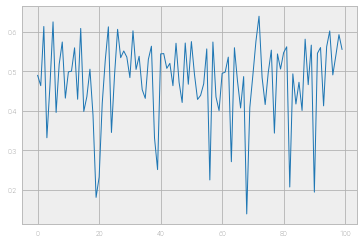

In [14]:
import matplotlib.pyplot as plt
plt.plot(corrs)

In [15]:
print(np.where(corrs == corrs.min()))

(array([68]),)


In [16]:
print(corrs.min())

0.13888378


In [17]:
np.inner(embed([df_sales['publicremarks'].values[501]]).numpy(),embed([df_sales['publicremarks'].values[1263]]).numpy())

array([[0.54446]], dtype=float32)

In [18]:
df_sales['publicremarks'].values[501]

'classic ranch house with a great floor plan and back yard. Back yard is fenced in and has a large workshop/garden shed and has a drilled well for irrigation of the yard. The home has a wonderful den/family room in addition to a living room with separate eating area. New windows throughout and a new outside compressor unit.'

In [19]:
df_sales['publicremarks'].values[1263]

'All Brick 6 Bedroom, 5 Bath home plus finished terrace level and screened-in porch AND an oversized detached garage that will fit an RV plus some! Located in North Oconee School District is this gem with unbelievable space. Once you enter the front door youll notice the elegant hardwood floors through out the main level. The dining room and large great room both have coffered ceilings. The open floor plan spotlights the great room and kitchen, perfect for entertaining guests. The spacious kitchen has custom cabinets, granite countertops, tile backsplash, double ovens and stainless steel appliances. The main floor is complete with a formal living room, guest suite and full bath. Upstairs is a large open loft area and 4 Bedrooms including the extremely spacious master suite w/ sitting area and fireplace. The master suite has his and her walk in closets, separate dual vanities with granite tops, a soaking garden tub and a large separate tiled shower. Down to the terrace level youll first

In [20]:
np.inner(embed([df_sales['publicremarks'].values[501]]).numpy(),embed([df_sales['publicremarks'].values[100]]).numpy())

array([[0.49309143]], dtype=float32)

In [21]:
df_sales['publicremarks'].values[100]

'BIG, PRIVATE CORNER LOT is the framework for this immaculate 3 bedroom, 2 bath ranch in popular MUNDY MILL Subdivision. Great first time homebuyer or downsizer home. WIDE OPEN FOYER, adorned with WAINSCOTING, opens to the VAULTED CEILING great room, kitchen and breakfast area. The GAS FIREPLACE is situated in the great room for all to enjoy whether cooking or lounging.You?ll find lots of cabinet space as well as a LARGE DOUBLE DOOR PANTRY. HARDWOODS throughout the main living area. The MUD ROOM is conveniently off the kitchen and'

In [22]:

for column in columns:
    print(column)
    tic = time.clock()
    new_column = column + '_embeddings'
    df_sales[new_column] = df_sales[column].apply(lambda x: embed([x]).numpy()) 
    toc = time.clock()
    print(toc - tic)

publicremarks
15206.743339999999
clean_publicremarks
14871.069525
clean_publicremarks_additional_words
14710.937297999997
clean_publicremarks_nopunct
14536.992895999996
clean_publicremarks_stemmed
14487.938182000005
clean_publicremarks_lemmatized
14507.091557000007


In [23]:
df_sales_save = df_sales

In [24]:
df_sales_save

,listingid,asgpropid,qtr,tax_year,cbsa_div,cbsa,state,Transdate,Transprice,bedrooms,...,clean_publicremarks_stemmed_additional_words_vaderpolarity,clean_publicremarks_lemmatized_vaderpolarity,clean_publicremarks_lemmatized_additional_words_vaderpolarity,sentence_composition,publicremarks_embeddings,clean_publicremarks_embeddings,clean_publicremarks_additional_words_embeddings,clean_publicremarks_nopunct_embeddings,clean_publicremarks_stemmed_embeddings,clean_publicremarks_lemmatized_embeddings
0,226661582,27649366.0,202008,2020.0,23580,23580,GA,20200811,359000.0,4.0,...,"{'compound': 0.4939, 'neg': 0.0, 'neu': 0.954,...","{'compound': 0.9578, 'neg': 0.0, 'neu': 0.786,...","{'compound': 0.93, 'neg': 0.0, 'neu': 0.81, 'p...","[55.00000000000001, 13.750000000000002, 17.5, ...","[[-0.018459855, -0.023812085, -0.043892566, -0...","[[-0.051987942, -0.054606345, -0.0580922, -0.0...","[[-0.05043851, -0.056709077, -0.055227116, -0....","[[-0.051987942, -0.054606345, -0.0580922, -0.0...","[[-0.038664196, -0.05890688, -0.06525755, -0.0...","[[-0.04986923, -0.05113033, -0.060150877, -0.0..."
1,226786904,27628370.0,202008,2020.0,29300,29300,GA,20200925,265000.0,4.0,...,"{'compound': 0.9686, 'neg': 0.0, 'neu': 0.799,...","{'compound': 0.9875, 'neg': 0.014, 'neu': 0.70...","{'compound': 0.9844, 'neg': 0.016, 'neu': 0.70...","[60.18518518518518, 13.88888888888889, 18.5185...","[[-0.060909368, -0.044562507, -0.048587322, -0...","[[-0.06049352, -0.05438737, -0.048537098, -0.0...","[[-0.059828583, -0.05020684, -0.046291806, -0....","[[-0.06049352, -0.05438737, -0.048537098, -0.0...","[[-0.065291695, -0.06122866, -0.04930517, 0.00...","[[-0.060174935, -0.05459462, -0.045611445, -0...."
2,226142320,27963359.0,202005,2020.0,27600,27600,GA,20200624,239900.0,4.0,...,"{'compound': 0.3182, 'neg': 0.0, 'neu': 0.957,...","{'compound': 0.8074, 'neg': 0.0, 'neu': 0.858,...","{'compound': 0.8074, 'neg': 0.0, 'neu': 0.855,...","[60.37735849056604, 9.433962264150944, 24.5283...","[[0.051360507, -0.007422204, -0.054501485, -0....","[[-0.015618877, -0.03321094, -0.064131856, -0....","[[-0.011177328, -0.034213364, -0.06423391, -0....","[[-0.015618877, -0.03321094, -0.064131856, -0....","[[-0.026406875, -0.061117634, -0.071621135, -0...","[[-0.026331514, -0.048204094, -0.06567335, -0...."
3,226738459,27516267.0,202008,2020.0,29300,29300,GA,20200713,130900.0,3.0,...,"{'compound': 0.0, 'neg': 0.0, 'neu': 1.0, 'pos...","{'compound': 0.0, 'neg': 0.0, 'neu': 1.0, 'pos...","{'compound': 0.0, 'neg': 0.0, 'neu': 1.0, 'pos...","[53.84615384615385, 7.6923076923076925, 38.461...","[[-0.020899976, 0.016856506, -0.011256389, -0....","[[-0.028272344, -0.005281781, -0.0073222406, -...","[[0.0036934454, 0.047616564, -0.0056924997, 0....","[[-0.028272344, -0.005281781, -0.0073222406, -...","[[-0.050069433, 0.007041185, -0.033259477, -0....","[[-0.028272344, -0.005281781, -0.0073222406, -..."
4,226850183,27791872.0,202008,2020.0,23580,23580,GA,20200702,406000.0,4.0,...,"{'compound': 0.2023, 'neg': 0.0, 'neu': 0.969,...","{'compound': 0.802, 'neg': 0.0, 'neu': 0.876, ...","{'compound': 0.6908, 'neg': 0.0, 'neu': 0.908,...","[65.57377049180327, 13.114754098360656, 11.475...","[[-0.047313046, 0.00859506, -0.04837404, -0.05...","[[-0.055047132, -0.031499583, -0.055006824, -0...","[[-0.053909175, -0.025725972, -0.05363282, -0....","[[-0.055047132, -0.031499583, -0.055006824, -0...","[[-0.061100535, -0.05123385, -0.067388244, -0....","[[-0.054386344, -0.04275706, -0.052802, -0.031..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
633866,77898274,106321613.0,200708,2013.0,27600,27600,GA,20070719,163900.0,NaN,...,"{'compound': 0.5574, 'neg': 0.0, 'neu': 0.839,...","{'compound': 0.5574, 'neg': 0.0, 'neu': 0.85, ...","{'compound': 0.5574, 'neg': 0.0, 'neu': 0.839,...","[57.14285714285714, 17.857142857142858, 14.285...","[[-0.051895734, -0.034251053, 0.033765092, -0....","[[-0.060446255, -0.039059404, -0.010817213, 0....","[[-0.05962046, -0.036440928

In [25]:
df_sales['clean_publicremarks_stemmed_embeddings'] = df_sales['clean_publicremarks_stemmed_embeddings'].apply(lambda x: x[0].reshape(len(x[0])))

In [26]:
df_sales['clean_publicremarks_nopunct_embeddings'] = df_sales['clean_publicremarks_nopunct_embeddings'].apply(lambda x: x[0].reshape(len(x[0])))

In [27]:
df_sales['clean_publicremarks_additional_words_embeddings'] = df_sales['clean_publicremarks_additional_words_embeddings'].apply(lambda x: x[0].reshape(len(x[0])))

In [28]:
df_sales['publicremarks_embeddings'] = df_sales['publicremarks_embeddings'].apply(lambda x: x[0].reshape(len(x[0])))

In [29]:
df_sales['clean_publicremarks_lemmatized_embeddings'] = df_sales['clean_publicremarks_lemmatized_embeddings'].apply(lambda x: x[0].reshape(len(x[0])))

In [30]:
df_sales['clean_publicremarks_embeddings'] = df_sales['clean_publicremarks_embeddings'].apply(lambda x: x[0].reshape(len(x[0])))

In [31]:
#df_sales['clean_publicremarks_stemmed_embeddings'][0][0].reshape(len(df_sales['clean_publicremarks_stemmed_embeddings'][0][0])).shape

TypeError: object of type 'numpy.float32' has no len()

In [32]:
df_sales

,listingid,asgpropid,qtr,tax_year,cbsa_div,cbsa,state,Transdate,Transprice,bedrooms,...,clean_publicremarks_stemmed_additional_words_vaderpolarity,clean_publicremarks_lemmatized_vaderpolarity,clean_publicremarks_lemmatized_additional_words_vaderpolarity,sentence_composition,publicremarks_embeddings,clean_publicremarks_embeddings,clean_publicremarks_additional_words_embeddings,clean_publicremarks_nopunct_embeddings,clean_publicremarks_stemmed_embeddings,clean_publicremarks_lemmatized_embeddings
0,226661582,27649366.0,202008,2020.0,23580,23580,GA,20200811,359000.0,4.0,...,"{'compound': 0.4939, 'neg': 0.0, 'neu': 0.954,...","{'compound': 0.9578, 'neg': 0.0, 'neu': 0.786,...","{'compound': 0.93, 'neg': 0.0, 'neu': 0.81, 'p...","[55.00000000000001, 13.750000000000002, 17.5, ...","[-0.018459855, -0.023812085, -0.043892566, -0....","[-0.051987942, -0.054606345, -0.0580922, -0.03...","[-0.05043851, -0.056709077, -0.055227116, -0.0...","[-0.051987942, -0.054606345, -0.0580922, -0.03...","[-0.038664196, -0.05890688, -0.06525755, -0.02...","[-0.04986923, -0.05113033, -0.060150877, -0.03..."
1,226786904,27628370.0,202008,2020.0,29300,29300,GA,20200925,265000.0,4.0,...,"{'compound': 0.9686, 'neg': 0.0, 'neu': 0.799,...","{'compound': 0.9875, 'neg': 0.014, 'neu': 0.70...","{'compound': 0.9844, 'neg': 0.016, 'neu': 0.70...","[60.18518518518518, 13.88888888888889, 18.5185...","[-0.060909368, -0.044562507, -0.048587322, -0....","[-0.06049352, -0.05438737, -0.048537098, -0.05...","[-0.059828583, -0.05020684, -0.046291806, -0.0...","[-0.06049352, -0.05438737, -0.048537098, -0.05...","[-0.065291695, -0.06122866, -0.04930517, 0.006...","[-0.060174935, -0.05459462, -0.045611445, -0.0..."
2,226142320,27963359.0,202005,2020.0,27600,27600,GA,20200624,239900.0,4.0,...,"{'compound': 0.3182, 'neg': 0.0, 'neu': 0.957,...","{'compound': 0.8074, 'neg': 0.0, 'neu': 0.858,...","{'compound': 0.8074, 'neg': 0.0, 'neu': 0.855,...","[60.37735849056604, 9.433962264150944, 24.5283...","[0.051360507, -0.007422204, -0.054501485, -0.0...","[-0.015618877, -0.03321094, -0.064131856, -0.0...","[-0.011177328, -0.034213364, -0.06423391, -0.0...","[-0.015618877, -0.03321094, -0.064131856, -0.0...","[-0.026406875, -0.061117634, -0.071621135, -0....","[-0.026331514, -0.048204094, -0.06567335, -0.0..."
3,226738459,27516267.0,202008,2020.0,29300,29300,GA,20200713,130900.0,3.0,...,"{'compound': 0.0, 'neg': 0.0, 'neu': 1.0, 'pos...","{'compound': 0.0, 'neg': 0.0, 'neu': 1.0, 'pos...","{'compound': 0.0, 'neg': 0.0, 'neu': 1.0, 'pos...","[53.84615384615385, 7.6923076923076925, 38.461...","[-0.020899976, 0.016856506, -0.011256389, -0.0...","[-0.028272344, -0.005281781, -0.0073222406, -0...","[0.0036934454, 0.047616564, -0.0056924997, 0.0...","[-0.028272344, -0.005281781, -0.0073222406, -0...","[-0.050069433, 0.007041185, -0.033259477, -0.0...","[-0.028272344, -0.005281781, -0.0073222406, -0..."
4,226850183,27791872.0,202008,2020.0,23580,23580,GA,20200702,406000.0,4.0,...,"{'compound': 0.2023, 'neg': 0.0, 'neu': 0.969,...","{'compound': 0.802, 'neg': 0.0, 'neu': 0.876, ...","{'compound': 0.6908, 'neg': 0.0, 'neu': 0.908,...","[65.57377049180327, 13.114754098360656, 11.475...","[-0.047313046, 0.00859506, -0.04837404, -0.052...","[-0.055047132, -0.031499583, -0.055006824, -0....","[-0.053909175, -0.025725972, -0.05363282, -0.0...","[-0.055047132, -0.031499583, -0.055006824, -0....","[-0.061100535, -0.05123385, -0.067388244, -0.0...","[-0.054386344, -0.04275706, -0.052802, -0.0314..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
633866,77898274,106321613.0,200708,2013.0,27600,27600,GA,20070719,163900.0,NaN,...,"{'compound': 0.5574, 'neg': 0.0, 'neu': 0.839,...","{'compound': 0.5574, 'neg': 0.0, 'neu': 0.85, ...","{'compound': 0.5574, 'neg': 0.0, 'neu': 0.839,...","[57.14285714285714, 17.857142857142858, 14.285...","[-0.051895734, -0.034251053, 0.033765092, -0.0...","[-0.060446255, -0.039059404, -0.010817213, 0.0...","[-0.05962046, -0.036440928,

In [33]:
df_sales.to_feather(file + '_withembeddings.fea')

In [ ]:
word = "Elephant"
sentence = "I am a sentence for which I would like to get its embedding."
paragraph = (
    "Universal Sentence Encoder embeddings also support short paragraphs. "
    "There is no hard limit on how long the paragraph is. Roughly, the longer "
    "the more 'diluted' the embedding will be.")
messages = [word, sentence, paragraph]

message_embeddings = embed(messages)

for i, message_embedding in enumerate(np.array(message_embeddings).tolist()):
    print("Message: {}".format(messages[i]))
    print("Embedding size: {}".format(len(message_embedding)))
    message_embedding_snippet = ", ".join(
      (str(x) for x in message_embedding[:3]))
    print("Embedding: [{}, ...]\n".format(message_embedding_snippet))

In [ ]:
def plot_similarity(labels, features, rotation):
    corr = np.inner(features, features)
    sns.set(font_scale=1.2)
    g = sns.heatmap(
      corr,
      xticklabels=labels,
      yticklabels=labels,
      vmin=0,
      vmax=1,
      cmap="YlOrRd")
    g.set_xticklabels(labels, rotation=rotation)
    g.set_title("Semantic Textual Similarity")

def run_and_plot(messages_):
    message_embeddings_ = embed(messages_)
    plot_similarity(messages_, message_embeddings_, 90)
    
    
    
def run_and_plot2(messages_):
    
    message_embeddings_ = []
    for txt in messages_:
        message_embeddings_.append(bert_embedding(txt))
        
    plot_similarity(messages_, message_embeddings_, 90)

In [ ]:
messages = [
    # Smartphones
    "I like my phone",
    "My phone is not good.",
    "Your cellphone looks great.",

    # Weather
    "Will it snow tomorrow?",
    "Recently a lot of hurricanes have hit the US",
    "Global warming is real",

    # Food and health
    "An apple a day, keeps the doctors away",
    "Eating strawberries is healthy",
    "Is paleo better than keto?",

    # Asking about age
    "How old are you?",
    "what is your age?",
]

run_and_plot(messages)

In [ ]:
word = "Elephant"
sentence = "I am a sentence for which I would like to get its embedding."
paragraph = (
    "Universal Sentence Encoder embeddings also support short paragraphs. "
    "There is no hard limit on how long the paragraph is. Roughly, the longer "
    "the more 'diluted' the embedding will be.")
messages = [word, sentence, paragraph]

message_embeddings = []
for txt in messages:
    message_embeddings.append(bert_embedding(txt))

for i, message_embedding in enumerate(np.array(message_embeddings).tolist()):
    print("Message: {}".format(messages[i]))
    print("Embedding size: {}".format(len(message_embedding)))
    message_embedding_snippet = ", ".join(
      (str(x) for x in message_embedding[:3]))
    print("Embedding: [{}, ...]\n".format(message_embedding_snippet))

In [ ]:
messages = [
    # Smartphones
    "I like my phone",
    "My phone is not good.",
    "Your cellphone looks great.",

    # Weather
    "Will it snow tomorrow?",
    "Recently a lot of hurricanes have hit the US",
    "Global warming is real",

    # Food and health
    "An apple a day, keeps the doctors away",
    "Eating strawberries is healthy",
    "Is paleo better than keto?",

    # Asking about age
    "How old are you?",
    "what is your age?",
]

run_and_plot2(messages)